In [1]:
#Import / download all necessary packages
import missingno as mo
import pandas as pd
import numpy as np
import plotly as plotly
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import ndimage
import geopandas
from geopandas.geodataframe import GeoDataFrame
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
import seaborn as sns
import folium
import math
import re

In [2]:
# Read in the data
df = pd.read_csv('Bridge_data_with_link_to_traffic.csv')
df2 = pd.read_csv('data_traffic_road_segments.csv')
# Make coordinates from the latitude and longitude
df['Coordinates'] = list(zip(df.lon, df.lat))
df['Coordinates'] = df['Coordinates'].apply(Point)
gdfc = GeoDataFrame(df, geometry='Coordinates')
# Make a dict to assign a color based on the vulnerability value
d={}
d['A'] = 0
d['B'] = 0.3
d['C'] = 0.6
d['D'] = 1.0
df2.drop(df2.index[[894]], inplace = True)

In [3]:
# Only run the line below if you just want to plot 1 road (or more) instead of all roads
#gdfc = gdfc[gdfc['road'] == 'N1' ]

In [4]:
# First create a map using the folium Package
Bangladesh = folium.Map(tiles="cartodbpositron")
# Then make a colormap to visualise a certain aspect, in this case the vulnerability, and add this colormap to the map
vmax = float(df2['Economic Traffic'].max())
linear = folium.LinearColormap(['green','yellow','red'], vmin=0., vmax=vmax)
linear.caption = 'Measure of Criticality where red is most critical and green the least'
Bangladesh.add_child(linear)
# Create all the information we want to show in the pop-up in a html format
def popopHTMLString(point,color):
    html = 'LRP: '
    html += point.LRPName
    
    html += ' <br>'
    html += 'Categorie: '
    html += point.condition
    
    html += ' <br>'
    html += 'Economic value: '
    html += str(color)
    
    html += ' <br>'
    html += 'Road Name: '
    html += point.road
    
    return html
# Now we iterate through our dataframe and add all points to the map. We extract from every row the value of the vulnerability
# and use the colormap to assign a color to that specific value
def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''   
    # This if statement below is to correct for the cells that have no value
    if len(df2.loc[df2['Link no'] == point.Road_segment_no, 'Economic Traffic']) > 0 :
        color = int(df2.loc[df2['Link no'] == point.Road_segment_no, 'Economic Traffic'])
    else:
        color = 0
    # Create a string to show in the pop-up
    htmlString = folium.Html(popopHTMLString(point,color), script=True)
    folium.CircleMarker(location=[point.lat, point.lon],
                        radius=3,
                        weight=2,
                        popup = folium.Popup(htmlString),
                        color = linear(color),
                        fill_opacity=d[point.condition],
                        line_opacity=1,                        
                        fill_color=linear(color)).add_to(Bangladesh) 
# We use df.apply(,axis=1) to iterate through every row in your dataframe
gdfc.apply(plotDot, axis = 1)

# Here we set the zoom to the maximum possible, to always have the right view when showing just one road or all
Bangladesh.fit_bounds(Bangladesh.get_bounds())

# Save our map to an HTML file
Bangladesh.save('Bangladesh_Criticality.html')
# Plot it below (plotting with all bridges is too much to ask apperently. It will only plot in the notebook with a few roads)
# The HTML will always be outputted however
# Bangladesh

In [5]:
# Make a dict to assign a color based on the vulnerability value 
d={}
d['A'] = 'green'
d['B'] = 'yellow'
d['C'] = 'orange'
d['D'] = 'red'

In [6]:
# First create a map using the folium Package
Bangladesh = folium.Map(tiles="cartodbpositron")
# Then make a colormap to visualise a certain aspect, in this case the vulnerability, and add this colormap to the map
vmax = float(df2['Economic Traffic'].max())
linear = folium.LinearColormap(['green','yellow','red'], vmin=0., vmax=1)
linear.caption = 'Measure of Vulnerability where red is most vulnerable and green the least'
Bangladesh.add_child(linear)
# Create all the information we want to show in the pop-up in a html format
def popopHTMLString(point,color):
    html = 'LRP: '
    html += point.LRPName
    
    html += ' <br>'
    html += 'Categorie: '
    html += point.condition
    
    html += ' <br>'
    html += 'Economic value: '
    html += str(color)
    
    html += ' <br>'
    html += 'Road Name: '
    html += point.road
    
    return html
# Now we iterate through our dataframe and add all points to the map. We extract from every row the value of the vulnerability
# and use the colormap to assign a color to that specific value
def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''   
    # This if statement below is to correct for the cells that have no value
    # There are only a few points with NaN, and they are displayed as green.
    if len(df2.loc[df2['Link no'] == point.Road_segment_no, 'Economic Traffic']) > 0 :
        color = int(df2.loc[df2['Link no'] == point.Road_segment_no, 'Economic Traffic'])
    else:
        color = 0
    # Create a string to show in the pop-up
    htmlString = folium.Html(popopHTMLString(point,color), script=True)
    folium.CircleMarker(location=[point.lat, point.lon],
                        radius=4,
                        weight=2,
                        popup = folium.Popup(htmlString),
                        color = d[point.condition],
                        fill_opacity=color/vmax,
                        line_opacity=1,                        
                        fill_color=d[point.condition]).add_to(Bangladesh) 
# We use df.apply(,axis=1) to iterate through every row in your dataframe
gdfc.apply(plotDot, axis = 1)

# Here we set the zoom to the maximum possible, to always have the right view when showing just one road or all
Bangladesh.fit_bounds(Bangladesh.get_bounds())

# Save our map to an HTML file
Bangladesh.save('Bangladesh_Vulnerability.html')
# Plot it below (plotting with all bridges is too much to ask apperently. It will only plot in the notebook with a few roads)
# The HTML will always be outputted however
# Bangladesh

In [7]:
# This function creates a heatmap based on the number of bridges. Red indicates that there are many bridges, where blue indicated there are none, with orange and yellow in the middle.
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.figure(figsize=(10,15))
    plt.savefig('heatmap.png', dpi=100)
    plt.show()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning:

divide by zero encountered in log



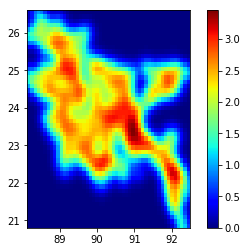

<Figure size 720x1080 with 0 Axes>

In [8]:
heatmap(gdfc, bins=50, smoothing=1.5)

In [9]:
df = pd.read_csv('Traffic_segment_data.csv')
df.drop(df.columns[0:2], axis=1,inplace = True)
df.drop('segment_vulnerability_length', axis = 1, inplace = True)
df.drop('missing_segment', axis = 1, inplace = True)
df=df.rename(columns = {'segment_vulnerability_normalized':'Vulnerability'})
df=df.rename(columns = {'Economic_Traffic_normalized':'Criticality'})
df.Criticality = df.Criticality.apply(pd.to_numeric)
df.dropna(inplace=True)

In [10]:
# First select the road you want to display
road = 'N1'
df = df[df['Road_Name'] == road ]

In [11]:
hover_text = []
# Iterate through all the rows and create the text we want to show when hovering over a certain data point. Add this to the column Text
for index, row in df.iterrows():
    hover_text.append(('Criticality: {criticality}<br>'+
                      'Vulnerability: {vulnerability}<br>' + 
                       'Road name: {roadname}<br>' + 
                       'Start LRP: {startLRP}<br>' + 
                       'End LRP: {endLRP}'
                      ).format(criticality=round(row['Criticality'],2),
                               vulnerability=round(row['Vulnerability'],2),
                               roadname=row['Road_Name'],
                               startLRP=row['Start LRP'],
                               endLRP=row['End LRP'])
                     )
df['Text'] = hover_text
data = []
# Get a list of all different modes of transport
modes = list(df)[12:28]
# Create the same number of traces, so we can switch on and off the different modes of transport
traces = ['trace' + str(i) for i in range(1,len(modes)+1)] 
# Define the traces with on the x-axis the Criticality and on the y-axis the Vulnerability 
# and make the size correspond to the density of that mode of transport
for trace, mode in zip(traces, modes):
    sizeref = 2.*max(df[mode])/(100**2)
    trace = go.Scatter(
        x=df['Criticality'], 
        y=df['Vulnerability'],
        mode='markers',
        name=mode,
        text=df['Text'],
        marker=dict(
            symbol='circle',
            sizemode='area',
            sizeref=sizeref,
            size=df[mode]/3,
            line=dict(
                width=2
            ),
        )
    )
    data.append(trace)
    
data = data
# Add the layout to the map. This includes the legend, title and the settings for the axes
layout = go.Layout(
    hovermode = 'closest',
    title='Criticality versus Vulnerability for all Modes of Transport by road segment',
    annotations=[
        dict(
            x=1.12,
            y=1.05,
            align="right",
            valign="top",
            text='Modes of transport',
            showarrow=False,
            xref="paper",
            yref="paper",
            xanchor="center",
            yanchor="top",
        )],
    xaxis=dict(
        title='Criticality',
        gridcolor='rgb(255, 255, 255)',
        range=[0,1],
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Vulnerability',
        gridcolor='rgb(255, 255, 255)',
        range=[0,0.2],
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,visible = 'legendonly', filename='life-expectancy-per-GDP-2007')

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

